In [1]:
# Mount google drive

from google.colab import drive
drive.mount('/content/drive')

#%pip install scikit-learn lxml

import pandas as pd
import json
import os
import glob
from lxml import etree
import ast
from natsort import natsorted


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
#%pip install sentence-transformers

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity


Mounted at /content/drive


In [2]:

# File paths
main_directory = "/content/drive/My Drive/266_NLP/final project/"
directory = "/content/drive/My Drive/266_NLP/final project/"
model_directory = "/content/drive/My Drive/266_NLP/final project/models/e5-base-v2/"
output_csv = "/content/drive/My Drive/266_NLP/final project/uspto_patents_cpc_metadata.csv"


In [ ]:
import os
import glob
from lxml import etree
import json
import pandas as pd

def extract_all_claims(root):
    claims = root.findall(".//claims/claim")
    all_claims = []
    for claim in claims:
        parts = claim.findall(".//claim-text")
        claim_text = " ".join(p.text.strip() for p in parts if p.text)
        all_claims.append(claim_text)  # Removed claim_number
    return all_claims

def extract_patent_metadata(xml_path):
    print(f"Processing {xml_path}")
    try:
        tree = etree.parse(xml_path)
        root = tree.getroot()

        def gettext(xpath):
            el = root.find(xpath)
            return el.text.strip() if el is not None and el.text else None

        def getalltext(xpath):
            els = root.findall(xpath)
            return [el.text.strip() for el in els if el is not None and el.text]

        # Fetch all parts together
        sections = getalltext(".//classification-cpc/section")
        classes = getalltext(".//classification-cpc/class")
        subclasses = getalltext(".//classification-cpc/subclass")
        main_groups = getalltext(".//classification-cpc/main-group")
        subgroups = getalltext(".//classification-cpc/subgroup")

        # Zip CPC levels to produce full identifiers
        cpc_entries = list(zip(sections, classes, subclasses, main_groups, subgroups))

        def safe_join(*parts, sep=""):
            return sep.join(p for p in parts if p)

        metadata = {
            "file": os.path.basename(xml_path),
            "publication_number": gettext(".//publication-reference/document-id/doc-number"),
            "application_number": gettext(".//application-reference/document-id/doc-number"),
            "publication_date": gettext(".//publication-reference/document-id/date"),
            "application_date": gettext(".//application-reference/document-id/date"),
            "invention_title": gettext(".//invention-title"),

            # Construct full identifiers
            "section": sorted(set(sections)),
            "class": sorted(set(safe_join(s, c) for s, c, _, _, _ in cpc_entries if s and c)),
            "subclass": sorted(set(safe_join(s, c, sc) for s, c, sc, _, _ in cpc_entries if s and c and sc)),
            "main_group": sorted(set(safe_join(s, c, sc, mg) for s, c, sc, mg, _ in cpc_entries if s and c and sc and mg)),
            "subgroup": sorted(set(safe_join(s, c, sc, mg, "-" + sg) for s, c, sc, mg, sg in cpc_entries if s and c and sc and mg and sg)),

            "country": gettext(".//country"),
            "abstract": gettext(".//abstract/p"),
            "assignee": gettext(".//assignees/assignee/addressbook/orgname"),
            "inventor_1": gettext(".//inventors/inventor[1]/addressbook/last-name"),
            "inventor_2": gettext(".//inventors/inventor[2]/addressbook/last-name"),
            "claims": extract_all_claims(root),
        }

        return metadata
    except Exception as e:
        return {"file": os.path.basename(xml_path), "error": str(e)}


def extract_from_directory(directory):
    xml_files = glob.glob(os.path.join(directory, "*.xml"))
    print(f"Found {len(xml_files)} XML files in {directory}")
    return [extract_patent_metadata(path) for path in xml_files]

if not os.path.exists(output_csv):

  # Extract
  records = extract_from_directory(directory)

  # Save JSON
  #with open(output_json, "w", encoding="utf-8") as f:
  #    json.dump(records, f, indent=2)

  # Save CSV
  df = pd.DataFrame(records)
  df["section"] = df["section"].apply(lambda x: ",".join(sorted(set(x))) if isinstance(x, list) else x)
  df["claims"] = df["claims"].apply(lambda x: " ".join(x) if isinstance(x, list) else "")
  df["combined_text"] = (
      df["invention_title"].fillna("") + " " +
      df["abstract"].fillna("") + " " +
      df["claims"]
  ).str.lower()

  df.to_csv(output_csv, index=False)

  print(f"Extracted {len(records)} files. Saved to JSON and CSV.")
  del records


Top IPC Sections:
section
H      4048
G      3736
A      1875
B      1349
G,H    1211
C       640
F       582
A,C     453
B,G     390
A,G     327
Name: count, dtype: int64


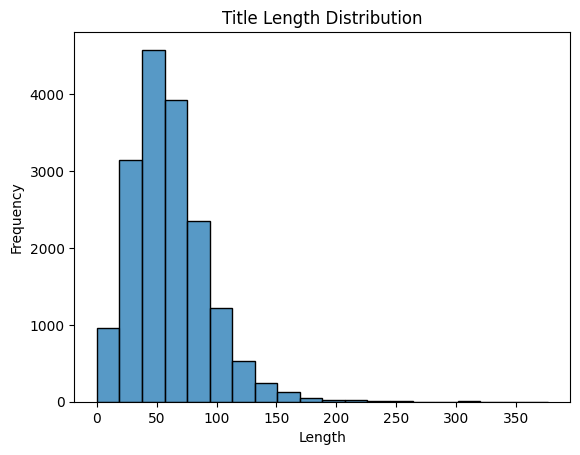

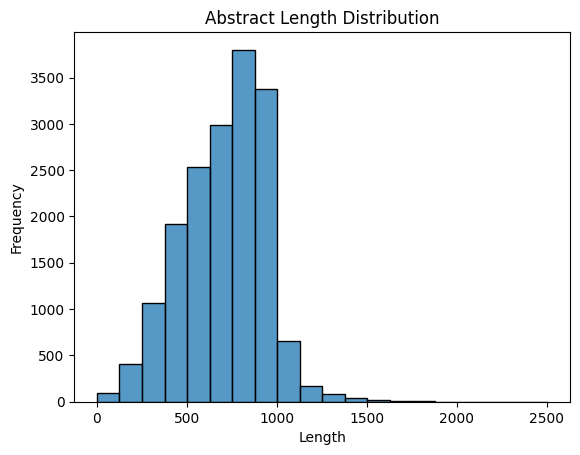

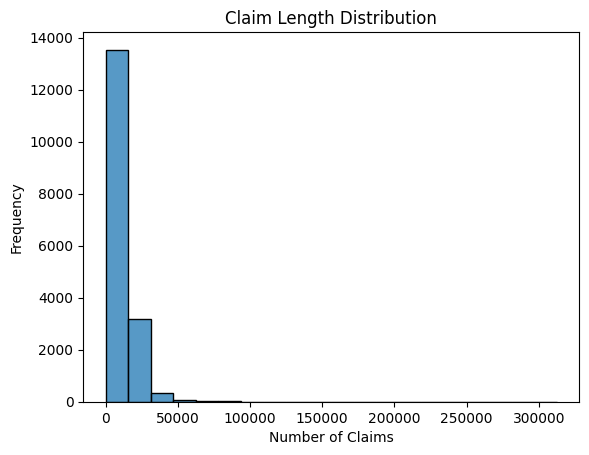

In [3]:
df=pd.read_csv(main_directory + "uspto_patents_cpc_metadata.csv")
df = df.dropna(subset=['section'])
#df_all = df_all.dropna(subset=['class'])
# df_all = df_all.dropna(subset=['subclass'])
# df_all = df_all.dropna(subset=['main_group'])
# df_all = df_all.dropna(subset=['subgroup'])

# Distribution of IPC sections
print("\nTop IPC Sections:")
print(df['section'].value_counts().head(10))

# Distribution of invention titles' lengths
df['title_length'] = df['invention_title'].fillna('').apply(len)
df['abstract_length'] = df['abstract'].fillna('').apply(len)
df['claims_length'] = df['claims'].fillna('').apply(len)

# Histograms
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['title_length'], bins=20)
plt.title("Title Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

sns.histplot(df['abstract_length'], bins=20)
plt.title("Abstract Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

sns.histplot(df['claims_length'], bins=20)
plt.title("Claim Length Distribution")
plt.xlabel("Number of Claims")
plt.ylabel("Frequency")
plt.show()

In [4]:
df_all = df
# Figure out the unique sections and classes in the data
sections_classes = {}
for _,row in df_all.iterrows():
    sections = row.section.split(',')
    classes = ast.literal_eval(row['class'])
    for section in sections:
        if section not in sections_classes:
            sections_classes[section] = set()
    for c in classes:
      first_letter = c[0]
      sections_classes[first_letter].add(c)

sections_classes = dict(sorted(sections_classes.items()))
for section in sections_classes:
  sections_classes[section] = natsorted(sections_classes[section])
print(sections_classes)

df_cleaned, test_df = train_test_split(df_all, test_size=0.20, random_state=42)#, stratify=df_all['section'], random_state=42)

df_cleaned = df_cleaned.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

df_cleaned.head()


# df_cleaned = pd.read_csv(main_directory + "df_train.csv")
# test_df = pd.read_csv(main_directory + "df_test.csv")

{'A': ['A01', 'A21', 'A22', 'A23', 'A24', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A61', 'A62', 'A63'], 'B': ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'B33', 'B41', 'B42', 'B43', 'B44', 'B60', 'B61', 'B62', 'B63', 'B64', 'B65', 'B66', 'B67', 'B68', 'B81', 'B82'], 'C': ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C21', 'C22', 'C23', 'C25', 'C30', 'C40'], 'D': ['D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D07', 'D10', 'D21'], 'E': ['E01', 'E02', 'E03', 'E04', 'E05', 'E06', 'E21'], 'F': ['F01', 'F02', 'F03', 'F04', 'F05', 'F15', 'F16', 'F17', 'F21', 'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28', 'F41', 'F42'], 'G': ['G01', 'G02', 'G03', 'G04', 'G05', 'G06', 'G07', 'G08', 'G09', 'G10', 'G11', 'G16', 'G21'], 'H': ['H01', 'H02', 'H03', 'H04', 'H05', 'H10'], 'Y': ['Y02', 'Y04', 'Y10']}


,file,publication_number,application_number,publication_date,application_date,invention_title,section,class,subclass,main_group,subgroup,country,assignee,inventor_1,abstract,claims,combined_text,title_length,abstract_length,claims_length
0,doc_1371.xml,20250195720,18544429,20250619,20231219,SILICONE OIL IN WATER INJECTABLE FILLER COMPOS...,"A,C","['A61', 'C08']","['A61L', 'C08L']","['A61L2300', 'A61L2400', 'A61L2430', 'A61L27',...","['A61L2300-402', 'A61L2300-428', 'A61L2400-06'...",US,NaN,Mezzancello,A silicone oil in water composition that is an...,1. An injectable filler composition that can b...,silicone oil in water injectable filler compos...,90,461,2364
1,doc_8236.xml,20250202385,19066028,20250619,20250227,"CONTROL APPARATUS OF VIBRATION ACTUATOR, CONTR...",H,['H02'],['H02N'],['H02N2'],['H02N2-142'],US,NaN,MORITA,A control unit of a control apparatus for a vi...,1. A control apparatus of a vibration actuator...,"control apparatus of vibration actuator, contr...",110,843,25259
2,doc_17822.xml,12335647,18529767,20250617,20231205,Time-resolving computational image sensor arch...,H,['H04'],['H04N'],['H04N25'],"['H04N25-745', 'H04N25-75', 'H04N25-771']",US,"Samsung Electronics Co., Ltd.",Wang,A pixel for an image sensor includes a photon ...,1. A method for processing imaging data from a...,time-resolving computational image sensor arch...,117,542,6929
3,doc_9647.xml,20250203796,18981576,20250619,20241215,Cover for Electrical Devices,H,['H05'],['H05K'],['H05K5'],"['H05K5-0217', 'H05K5-03']",US,NaN,JADE,The present invention provides a cover assembl...,1. A cover assembly (100) for an electrical de...,cover for electrical devices the present inven...,28,803,10976
4,doc_5623.xml,20250199775,18543282,20250619,20231218,DESIGN TIME SMART ANALYZER AND RUNTIME SMART H...,G,['G06'],['G06F'],['G06F8'],"['G06F8-34', 'G06F8-35']",US,"UiPath, Inc.",GRIGORE,A design time smart analyzer and a runtime sma...,1. A non-transitory computer-readable medium s...,design time smart analyzer and runtime smart h...,83,426,22229


In [5]:
df_cleaned['combined_text'][0]

"silicone oil in water injectable filler composition used as a scaffold for collagen growth a silicone oil in water composition that is an injectable filler that is useful as a scaffold for collagen growth in a human. the injectable filler composition comprises of 1.0% to 80.0% of a silicone oil having a viscosity of 10000 centistokes, 20.0% to 80.0% of a water, and 1.5% to 3.0% of a thickening agent, wherein the filler composition is an oil in water emulsion, the silicone oil droplets will have an average diameter from 30 microns to 2000 microns. 1. an injectable filler composition that can be applied to humans who suffer from a collagen sensitivity that will stimulate collagen production, the injectable filler composition comprises:\nfrom about 1.0% to about 80.0% of a silicone oil having a viscosity of 10,000 centistokes;\nfrom about 20.0% to about 99.0% of a water; and\nfrom about 1.5% to about 3.0% of a thickening agent, wherein the injectable filler composition is an oil in water

In [6]:
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader


print("Fine-tuned model already exists. Loading...")
embedder = SentenceTransformer(model_directory + "fine_tuned_patent_model_e5-base-v2")


Fine-tuned model already exists. Loading...


In [7]:
df_all
#test_df

,file,publication_number,application_number,publication_date,application_date,invention_title,section,class,subclass,main_group,subgroup,country,assignee,inventor_1,abstract,claims,combined_text,title_length,abstract_length,claims_length
0,doc_17456.xml,12335277,17656250,20250617,20220324,Frame invalidation in the bus system including...,H,['H04'],['H04L'],"['H04L12', 'H04L2012', 'H04L63']","['H04L12-40013', 'H04L12-40019', 'H04L2012-402...",US,ROBERT BOSCH GMBH,Kneib,"A node device for a bus system, including a tr...","1. A node device for a bus system, comprising:...",frame invalidation in the bus system including...,73,883,20473
1,doc_16086.xml,12333894,18123626,20250617,20230320,Game management system to track game play by p...,G,['G07'],['G07F'],['G07F17'],"['G07F17-3206', 'G07F17-322', 'G07F17-3225', '...",US,"ANGEL GROUP CO., LTD.",Shigeta,A game management system that manages a casino...,1. A game management system for management of ...,game management system to track game play by p...,52,838,16357
2,doc_17388.xml,12335209,18382712,20250617,20231023,Method and system of obtaining contact informa...,"G,H","['G06', 'H04']","['G06F', 'G06Q', 'G06V', 'H04L']","['G06F40', 'G06Q10', 'G06V30', 'H04L51', 'H04L...","['G06F40-295', 'G06Q10-107', 'G06V30-224', 'H0...",US,"INTERDIGITAL CE PATENT HOLDINGS, SAS",Carr,A method of obtaining contact information for ...,1. A method comprising:\nproviding an indicati...,method and system of obtaining contact informa...,76,601,4947
3,doc_17155.xml,12334975,18110206,20250617,20230215,System for in-band spectral cross-talk monitoring,H,['H04'],['H04B'],['H04B10'],"['H04B10-0731', 'H04B10-801']",US,"Mellanox Technologies, Ltd.",Seyedi,Systems and methods are described for in-band ...,1. A system for in-band spectral cross-talk mo...,system for in-band spectral cross-talk monitor...,49,889,14721
4,doc_18568.xml,12336404,18645555,20250617,20240425,Display panel and display device including blo...,"G,H","['G06', 'G09', 'H10']","['G06F', 'G09G', 'H10K']","['G06F3', 'G09G2300', 'G09G2320', 'G09G2330', ...","['G06F3-00', 'G06F3-033', 'G09G2300-0426', 'G0...",US,"BOE TECHNOLOGY GROUP CO., LTD.",Wang,Disclosed are a display panel and a display de...,"1. A display panel, comprising:\na base substr...",display panel and display device including blo...,50,908,17627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17178,doc_4350.xml,20250198512,18979589,20250619,20241212,PISTON RING ASSEMBLY,F,['F16'],['F16J'],['F16J9'],['F16J9-18'],US,NaN,Moreira,A piston ring assembly is disclosed. The pisto...,"1. A piston ring assembly, comprising:\nan ann...",piston ring assembly a piston ring assembly is...,20,826,11268
17179,doc_484.xml,20250194926,19002416,20250619,20241226,Biometric Monitoring Systems and Methods,"A,G","['A61', 'G06', 'G16']","['A61B', 'G06F', 'G16H']","['A61B5', 'G06F9', 'G16H50']","['A61B5-0022', 'G06F9-455', 'G16H50-30']",US,NaN,Bonistalli,Computer implemented biometric methods and sys...,1-10. (canceled) 11. A server component config...,biometric monitoring systems and methods compu...,40,1012,16489
17180,doc_2748.xml,20250197094,19072181,20250619,20250306,DISPENSING PACKAGE FOR SHEET MATERIAL,"A,B","['A47', 'B65']","['A47K', 'B65D']","['A47K10', 'A47K2010', 'B65D2583', 'B65D5', 'B...","['A47K10-42', 'A47K2010-3233', 'B65D2583-082',...",US,NaN,Shihor,A hangable and expandable prism-shaped dispens...,1. A hangable and expandable prism-shaped disp...,dispensing package for sheet material a hangab...,37,621,5153
17181,doc_1731.xml,20250196077,18845689,20250619,20230301,SCREW ELEMENTS WITH IMPROVED MIXING EFFECT AND...,B,"['B01', 'B29']","['B01F', 'B29C']","['B01F2101', 'B01F2215', 'B01F27', 'B29C48']","['B01F2101-2805', 'B01F2215-0422', 'B01F2215-0...",US,NaN,Koenig,The invention relates to a four-flight screw e...,"1. A pair of four-flight screw elements, suita...",screw elements with improved mixing effect and...,64,693,10329


In [9]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import ast, os


In [16]:
# Run Section MoE with test_df
# Get the global test data in the right format
# This data will be all the data for our MOE classifier i.e
# We are not using the df_cleaned split which was used for finetuning our sentencetransformer model
# It is optionally possible to use all the dataset (including the finetuned one) i.e df_all
# However, we are also making sure that the embeddings of global test set are generated by our finetuned model
df=test_df.copy()
for col in ["class", "subclass", "main_group", "subgroup"]:
     df[col] = df[col].apply(ast.literal_eval)


# # -----------------------------------------------------------
# # 2. BUILD LABEL VOCABULARIES
# # -----------------------------------------------------------

# Extract unique classes from section column
print('Build label vocabularies for sections ...')
sections_list = sorted(list(sections_classes.keys()))
section_label_to_idx = {s: i for i, s in enumerate(sections_list)}
print(section_label_to_idx)
index_to_section_label = {i: s for s, i in section_label_to_idx.items()}
print(index_to_section_label)

# # # -----------------------------------------------------------
# # # 3. BUILD MULTI-HOT LABELS
# # # -----------------------------------------------------------
print()
print('Build multi-hot labels for sections per observations ...')
# Section labels
y_sections = []
for _, row in df.iterrows():
    multi_hot = np.zeros(len(sections_list))
    for section in row["section"]:
      if section in section_label_to_idx:
#          print(section)
          multi_hot[section_label_to_idx[section]] = 1
    y_sections.append(multi_hot)
y_sections = np.array(y_sections)
print('Number of observations:', len(y_sections))
#print(y_sections)

# # -----------------------------------------------------------
# # 4. GENERATE EMBEDDINGS
# # -----------------------------------------------------------
print()
#embeddings = embedder.encode(df["combined_text"].tolist())
if not os.path.exists(model_directory + "test_df_embeddings.npy"):
  print('Generate embeddings ...')
  embeddings = embedder.encode(df["combined_text"].tolist())
  np.save(model_directory + "test_df_embeddings.npy", embeddings)
else:
    print("Embeddings already exist. Loading embeddings...")
    embeddings = np.load(model_directory + "test_df_embeddings.npy")

embed_dim = embeddings.shape[1]
print('Embedding dimensions:', embeddings.shape)
# -----------------------------------------------------------
# 5. TRAIN-TEST SPLIT
# -----------------------------------------------------------
print()
print('Generate Train-test split ...')
# primary_labels = df["section"].tolist()

X_train, X_test, y_sec_train, y_sec_test = train_test_split(
    embeddings,
    y_sections,
    test_size=0.5,
    random_state=42 #,
#    stratify=y_sections
)

from sklearn.utils import resample
import numpy as np

# Identify index of 'D' and 'Y' in section labels
d_idx = section_label_to_idx.get('D')
y_idx = section_label_to_idx.get('Y')

assert d_idx is not None and y_idx is not None, "Check section label mapping"

# Combine X and y into one array
train_data = np.hstack((X_train, y_sec_train))
embed_dim = X_train.shape[1]

# Extract rows where D=1 and Y=1
d_rows = train_data[y_sec_train[:, d_idx] == 1]
y_rows = train_data[y_sec_train[:, y_idx] == 1]

# Choose target count (e.g., median or max class count)
target_count = int(np.median([y_sec_train[:, i].sum() for i in range(y_sec_train.shape[1])]))

# Upsample D
if len(d_rows) > 0:
    d_upsampled = resample(d_rows, replace=True, n_samples=target_count, random_state=42)
else:
    d_upsampled = np.empty((0, train_data.shape[1]))

# Upsample Y
if len(y_rows) > 0:
    y_upsampled = resample(y_rows, replace=True, n_samples=target_count, random_state=42)
else:
    y_upsampled = np.empty((0, train_data.shape[1]))

# Combine original + upsampled D + upsampled Y
balanced_data = np.vstack([train_data, d_upsampled, y_upsampled])
np.random.shuffle(balanced_data)

# Split back into X and y
X_train = balanced_data[:, :embed_dim]
y_sec_train = balanced_data[:, embed_dim:].astype(int)

# Optional: print updated label counts
print("\nBalanced label counts:")
for i, name in enumerate(sections_list):
    print(f"{name}: {y_sec_train[:, i].sum()}")


# -----------------------------------------------------------
# 6. DEFINE SIMPLE MoE MODULE
# -----------------------------------------------------------

class SimpleMoE(nn.Module):
    def __init__(self, embed_dim, num_outputs, num_experts, hidden_dim=256):
        super().__init__()
        self.gate = nn.Linear(embed_dim, num_experts)
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(embed_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, num_outputs)
            )
            for _ in range(num_experts)
        ])

    def forward(self, x):
        gating_logits = self.gate(x)
        gating_weights = F.softmax(gating_logits, dim=-1)

        expert_outputs = []
        for expert in self.experts:
            out = expert(x)
            expert_outputs.append(out.unsqueeze(1))

        expert_outputs = torch.cat(expert_outputs, dim=1)
        gating_weights = gating_weights.unsqueeze(-1)

        weighted_logits = (gating_weights * expert_outputs).sum(dim=1)
        return weighted_logits


# -----------------------------------------------------------
# 7. TRAIN SECTION MoE
# -----------------------------------------------------------
print()
print("Training Section MoE...")
num_sections = len(sections_list)
print(f"Number of sections: {num_sections}")
num_experts = 2
print(f"Number of experts: {num_experts}")

model_sec = SimpleMoE(embed_dim, num_sections, num_experts)
optimizer_sec = torch.optim.Adam(model_sec.parameters(), lr=2e-4)
criterion = nn.BCEWithLogitsLoss()

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_sec_train_tensor = torch.tensor(y_sec_train, dtype=torch.float32)

for epoch in range(2000):
    logits = model_sec(X_train_tensor)
    loss = criterion(logits, y_sec_train_tensor)

    optimizer_sec.zero_grad()
    loss.backward()
    optimizer_sec.step()

    print(f"[Section MoE] Epoch {epoch+1} Loss: {loss.item():.4f}")

# -----------------------------------------------------------
# 9. PREDICT ON TEST SET
# -----------------------------------------------------------
print()
print("Predicting on test set...")
model_sec.eval()

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

with torch.no_grad():
    sec_logits = model_sec(X_test_tensor)
    sec_probs = torch.sigmoid(sec_logits)
#    print(sec_probs)

sec_preds_binary = (sec_probs.numpy() >= 0.35).astype(int)
#print(sec_preds_binary)
#print(y_sec_test)
#print(sections_list)
# -----------------------------------------------------------
# 10. EVALUATE
# -----------------------------------------------------------
print()
print("\n=== SECTION CLASSIFICATION REPORT ===")
print(classification_report(
    y_sec_test,
    sec_preds_binary,
    target_names=sections_list,
    zero_division=0
))

from sklearn.metrics import confusion_matrix

for i, class_name in enumerate(sections_list):
    cm = confusion_matrix(y_sec_test[:, i], sec_preds_binary[:, i])
    print(f"{class_name}: TP={cm[1,1]}, FN={cm[1,0]}, FP={cm[0,1]}, TN={cm[0,0]}")


Build label vocabularies for sections ...
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'Y': 8}
{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'Y'}

Build multi-hot labels for sections per observations ...
Number of observations: 3437

Embeddings already exist. Loading embeddings...
Embedding dimensions: (3437, 768)

Generate Train-test split ...

Balanced label counts:
A: 425
B: 482
C: 293
D: 206
E: 50
F: 169
G: 751
H: 723
Y: 210

Training Section MoE...
Number of sections: 9
Number of experts: 2
[Section MoE] Epoch 1 Loss: 0.6960
[Section MoE] Epoch 2 Loss: 0.6943
[Section MoE] Epoch 3 Loss: 0.6925
[Section MoE] Epoch 4 Loss: 0.6908
[Section MoE] Epoch 5 Loss: 0.6891
[Section MoE] Epoch 6 Loss: 0.6874
[Section MoE] Epoch 7 Loss: 0.6858
[Section MoE] Epoch 8 Loss: 0.6842
[Section MoE] Epoch 9 Loss: 0.6826
[Section MoE] Epoch 10 Loss: 0.6809
[Section MoE] Epoch 11 Loss: 0.6793
[Section MoE] Epoch 12 Loss: 0.6777
[Section MoE] Epoch 13 Loss: 0.676

In [17]:
df

,file,publication_number,application_number,publication_date,application_date,invention_title,section,class,subclass,main_group,subgroup,country,assignee,inventor_1,abstract,claims,combined_text,title_length,abstract_length,claims_length
0,doc_4098.xml,20250198261,18851241,20250619,20230324,SUBSEA TERMINATION ASSEMBLY,E,[E21],[E21B],"[E21B41, E21B43]","[E21B41-10, E21B43-0107]",US,NaN,ABDUL,A subsea termination assembly comprising a mai...,1. A subsea termination assembly comprising\na...,subsea termination assembly a subsea terminati...,27,630,5329
1,doc_2829.xml,20250197175,19068124,20250619,20250303,MOBILE CRANE HAVING A COUNTERWEIGHT DEVICE,B,[B66],[B66C],[B66C23],"[B66C23-42, B66C23-74]",US,NaN,KÖNIG,The present invention relates to a mobile cran...,1. A mobile crane having a travelable undercar...,mobile crane having a counterweight device the...,42,469,9512
2,doc_13664.xml,12331459,17669882,20250617,20220211,Ragger systems and methods for removing solid ...,D,[D21],"[D21B, D21C]","[D21B1, D21C7]","[D21B1-32, D21B1-34, D21C7-12]",US,"KADANT BLACK CLAWSON, LLC",Demler,A ragger system for removing solid debris from...,1. A ragger system for removing solid debris f...,ragger systems and methods for removing solid ...,75,908,43235
3,doc_8799.xml,20250202948,18543244,20250619,20231218,RESOURCE-MONITORING TELEMETRY IN A ZERO-TRUST ...,H,[H04],[H04L],[H04L63],"[H04L63-10, H04L63-20]",US,"Dell Products, L.P.",Tan,Systems and methods provide collection of tele...,1. A system for collection of telemetry by an ...,resource-monitoring telemetry in a zero-trust ...,67,841,10368
4,doc_11365.xml,12329299,18540769,20250617,20231214,Rotary goblet,A,[A47],[A47G],[A47G19],[A47G19-2255],US,NaN,Lin,"A rotary goblet is provided, it comprises a go...","1. A rotary goblet, characterized in that it c...","rotary goblet a rotary goblet is provided, it ...",13,1365,3200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3432,doc_16169.xml,12333980,18596676,20250617,20240306,Electronic device with transparent display device,G,[G09],[G09G],"[G09G2300, G09G2310, G09G3]","[G09G2300-0404, G09G2310-0275, G09G3-20]",US,Innolux Corporation,Huang,The disclosure provides an electronic device i...,"1. An electronic device, comprising:\na frame;...",electronic device with transparent display dev...,49,848,3594
3433,doc_5560.xml,20250199712,18544331,20250619,20231218,CONVERTING PAGES WRITTEN IN A PAGE STORAGE DUR...,G,[G06],[G06F],[G06F3],"[G06F3-0604, G06F3-064, G06F3-0655, G06F3-0679]",US,NaN,VAN DER HOORN,Techniques are described herein that are capab...,1. A computing system comprising:\na processor...,converting pages written in a page storage dur...,119,847,25554
3434,doc_11189.xml,12329124,17979373,20250617,20221102,Animal toilet,A,[A01],[A01K],[A01K1],[A01K1-011],US,UNICHARM CORPORATION,Okawa,An animal litter box includes an upper contain...,1. An animal litter box comprising:\nan upper ...,animal toilet an animal litter box includes an...,13,527,4118
3435,doc_2754.xml,20250197100,19065708,20250619,20250227,PACKING MATERIAL,B,[B65],[B65D],"[B65D2585, B65D5, B65D81, B65D85]","[B65D2585-6897, B65D5-505, B65D5-5071, B65D81-...",US,FANUC CORPORATION,SHINAGAWA,Provided is a packing material that makes it p...,1. A packing material for packing an articulat...,packing material provided is a packing materia...,16,453,1831


In [10]:
# Run Section MoE with test_df with external experts
# Get the global test data in the right format
# This data will be all the data for our MOE classifier i.e
# We are not using the df_cleaned split which was used for finetuning our sentencetransformer model
# It is optionally possible to use all the dataset (including the finetuned one) i.e df_all
# However, we are also making sure that the embeddings of global test set are generated by our finetuned model
df=df_cleaned.copy()
for col in ["class", "subclass", "main_group", "subgroup"]:
     df[col] = df[col].apply(ast.literal_eval)


# # -----------------------------------------------------------
# # 2. BUILD LABEL VOCABULARIES
# # -----------------------------------------------------------

# Extract unique classes from section column
print('Build label vocabularies for sections ...')
sections_list = sorted(list(sections_classes.keys()))
section_label_to_idx = {s: i for i, s in enumerate(sections_list)}
print(section_label_to_idx)
index_to_section_label = {i: s for s, i in section_label_to_idx.items()}
print(index_to_section_label)

# # # -----------------------------------------------------------
# # # 3. BUILD MULTI-HOT LABELS
# # # -----------------------------------------------------------
print()
print('Build multi-hot labels for sections per observations ...')
# Section labels
y_sections = []
for _, row in df.iterrows():
    multi_hot = np.zeros(len(sections_list))
    for section in row["section"]:
      if section in section_label_to_idx:
#          print(section)
          multi_hot[section_label_to_idx[section]] = 1
    y_sections.append(multi_hot)
y_sections = np.array(y_sections)
print('Number of observations:', len(y_sections))
#print(y_sections)

# # -----------------------------------------------------------
# # 4. GENERATE EMBEDDINGS
# # -----------------------------------------------------------
print()
#embeddings = embedder.encode(df["combined_text"].tolist())
if not os.path.exists(model_directory + "df_cleaned_embeddings.npy"):
  print('Generate embeddings ...')
  embeddings = embedder.encode(df["combined_text"].tolist())
  np.save(model_directory + "df_cleaned_embeddings.npy", embeddings)
else:
    print("Embeddings already exist. Loading embeddings...")
    embeddings = np.load(model_directory + "df_cleaned_embeddings.npy")

embed_dim = embeddings.shape[1]
print('Embedding dimensions:', embeddings.shape)
# -----------------------------------------------------------
# 5. TRAIN-TEST SPLIT
# -----------------------------------------------------------
print()
print('Generate Train-test split ...')
# primary_labels = df["section"].tolist()

X_train, X_test, y_sec_train, y_sec_test = train_test_split(
    embeddings,
    y_sections,
    test_size=0.15,
    random_state=42 #,
#    stratify=y_sections
)

from sklearn.utils import resample
import numpy as np

# Identify index of 'D' and 'Y' in section labels
d_idx = section_label_to_idx.get('D')
y_idx = section_label_to_idx.get('Y')

assert d_idx is not None and y_idx is not None, "Check section label mapping"

# Combine X and y into one array
train_data = np.hstack((X_train, y_sec_train))
embed_dim = X_train.shape[1]

# Extract rows where D=1 and Y=1
d_rows = train_data[y_sec_train[:, d_idx] == 1]
y_rows = train_data[y_sec_train[:, y_idx] == 1]

# Choose target count (e.g., median or max class count)
target_count = int(np.median([y_sec_train[:, i].sum() for i in range(y_sec_train.shape[1])]))

# Upsample D
if len(d_rows) > 0:
    d_upsampled = resample(d_rows, replace=True, n_samples=target_count, random_state=42)
else:
    d_upsampled = np.empty((0, train_data.shape[1]))

# Upsample Y
if len(y_rows) > 0:
    y_upsampled = resample(y_rows, replace=True, n_samples=target_count, random_state=42)
else:
    y_upsampled = np.empty((0, train_data.shape[1]))

# Combine original + upsampled D + upsampled Y
balanced_data = np.vstack([train_data, d_upsampled, y_upsampled])
np.random.shuffle(balanced_data)

# Split back into X and y
X_train = balanced_data[:, :embed_dim]
y_sec_train = balanced_data[:, embed_dim:].astype(int)

# Optional: print updated label counts
print("\nBalanced label counts:")
for i, name in enumerate(sections_list):
    print(f"{name}: {y_sec_train[:, i].sum()}")


from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
import numpy as np
import os
from sklearn.preprocessing import MultiLabelBinarizer


df['section_list'] = df['section'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
mlb = MultiLabelBinarizer(classes=["A", "B", "C", "D", "E", "F", "G", "H", "Y"])
Y_all = mlb.fit_transform(df["section_list"])

# ====== Set your manual threshold here ======
threshold = 0.35  # You can adjust this

# ===== SimpleMoE Classifier =====
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleMoEClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, experts):
        self.experts = experts

    def fit(self, X, y):
        for _, model in self.experts:
            model.fit(X, y)
        return self

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] >= threshold).astype(int)

    def predict_proba(self, X):
        probas = []
        for _, model in self.experts:
            if hasattr(model, "predict_proba"):
                proba = model.predict_proba(X)
                if proba.shape[1] == 2:
                    proba = proba[:, 1]  # use positive class
                probas.append(proba)
            else:
                # Fallback for models without predict_proba
                probas.append(model.predict(X))
        avg_proba = np.mean(probas, axis=0)
        return np.vstack([1 - avg_proba, avg_proba]).T  # shape: (n_samples, 2)

# ===== Define Ensemble Experts =====
experts = [
    ("lr", LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs')),
    ("svc", CalibratedClassifierCV(LinearSVC(max_iter=1000, class_weight='balanced'))),
    ("knn", KNeighborsClassifier(n_neighbors=5))
]

# # ===== Report Path =====
# report_path = os.path.join(main_directory, "moe_finetuned_e5_evaluation_reports.txt")
# with open(report_path, "w") as f:
#     f.write(" Multi-Label Classification Report\n\n")

# ===== Train OneVsRest SimpleMoE =====
print("\n Training multi-label classifier: SimpleMoE (Threshold = {:.2f})".format(threshold))

if not os.path.exists(model_directory + "test_df_embeddings.npy"):
  print('Generate embeddings ...')
  embeddings_test = embedder.encode(test_df["combined_text"].tolist())
  np.save(model_directory + "test_df_embeddings.npy", embeddings)
else:
    print("Embeddings already exist. Loading embeddings...")
    embeddings_test = np.load(model_directory + "test_df_embeddings.npy")

y_sections_test = []
for _, row in test_df.iterrows():
    multi_hot = np.zeros(len(sections_list))
    for section in row["section"]:
      if section in section_label_to_idx:
#          print(section)
          multi_hot[section_label_to_idx[section]] = 1
    y_sections_test.append(multi_hot)
y_sections_test = np.array(y_sections_test)
print('Number of observations:', len(y_sections_test))

try:
    base_moe = SimpleMoEClassifier(experts)
    clf = OneVsRestClassifier(base_moe)
    clf.fit(X_train, y_sec_train)

    y_test_pred = clf.predict(embeddings_test)
    test_report = classification_report(y_sections_test, y_test_pred, target_names=mlb.classes_)

    print(f"\n Test Report for SimpleMoE (Threshold = {threshold}):")
    print(test_report)

    # # Save report to file
    # with open(report_path, "a") as f:
    #     f.write(f"\n=== SimpleMoE (Threshold = {threshold}) ===\n")
    #     f.write("Test Report:\n")
    #     f.write(test_report + "\n")
    #     f.write("=" * 60 + "\n")

except Exception as e:
    print(f" Error with SimpleMoE: {e}")
    # with open(report_path, "a") as f:
    #     f.write(f"\n Error with SimpleMoE: {e}\n")


Build label vocabularies for sections ...
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'Y': 8}
{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'Y'}

Build multi-hot labels for sections per observations ...
Number of observations: 13746

Embeddings already exist. Loading embeddings...
Embedding dimensions: (13746, 768)

Generate Train-test split ...

Balanced label counts:
A: 2793
B: 2762
C: 1871
D: 1414
E: 451
F: 1147
G: 4659
H: 4713
Y: 1427

 Training multi-label classifier: SimpleMoE (Threshold = 0.35)
Embeddings already exist. Loading embeddings...
Number of observations: 3437

 Test Report for SimpleMoE (Threshold = 0.35):
              precision    recall  f1-score   support

           A       0.86      0.84      0.85       647
           B       0.72      0.66      0.69       622
           C       0.81      0.78      0.79       367
           D       0.31      0.57      0.40        30
           E       0.54      0.68      0.60        99


In [ ]:

# Get the global test data in the right format
# This data will be all the data for our MOE classifier i.e
# We are not using the df_cleaned split which was used for finetuning our sentencetransformer model
# It is optionally possible to use all the dataset (including the finetuned one) i.e df_all
# However, we are also making sure that the embeddings of global test set are generated by our finetuned model
df=df_cleaned.copy()
for col in ["class", "subclass", "main_group", "subgroup"]:
     df[col] = df[col].apply(ast.literal_eval)


# # -----------------------------------------------------------
# # 2. BUILD LABEL VOCABULARIES
# # -----------------------------------------------------------

# Extract unique classes from section column
print('Build label vocabularies for sections ...')
sections_list = sorted(list(sections_classes.keys()))
section_label_to_idx = {s: i for i, s in enumerate(sections_list)}
print(section_label_to_idx)
index_to_section_label = {i: s for s, i in section_label_to_idx.items()}
print(index_to_section_label)

# # # -----------------------------------------------------------
# # # 3. BUILD MULTI-HOT LABELS
# # # -----------------------------------------------------------
print()
print('Build multi-hot labels for sections per observations ...')
# Section labels
y_sections = []
for _, row in df.iterrows():
    multi_hot = np.zeros(len(sections_list))
    for section in row["section"]:
      if section in section_label_to_idx:
#          print(section)
          multi_hot[section_label_to_idx[section]] = 1
    y_sections.append(multi_hot)
y_sections = np.array(y_sections)
print('Number of observations:', len(y_sections))
#print(y_sections)

# # -----------------------------------------------------------
# # 4. GENERATE EMBEDDINGS
# # -----------------------------------------------------------
print()
#embeddings = embedder.encode(df["combined_text"].tolist())
if not os.path.exists(model_directory + "df_cleaned_embeddings.npy"):
  print('Generate embeddings ...')
  embeddings = embedder.encode(df["combined_text"].tolist())
  np.save(model_directory + "df_cleaned_embeddings.npy", embeddings)
else:
    print("Embeddings already exist. Loading embeddings...")
    embeddings = np.load(model_directory + "df_cleaned_embeddings.npy")

embed_dim = embeddings.shape[1]
print('Embedding dimensions:', embeddings.shape)
# -----------------------------------------------------------
# 5. TRAIN-TEST SPLIT
# -----------------------------------------------------------
print()
print('Generate Train-test split ...')
# primary_labels = df["section"].tolist()

X_train, X_test, y_sec_train, y_sec_test = train_test_split(
    embeddings,
    y_sections,
    test_size=0.5,
    random_state=42 #,
#    stratify=y_sections
)

from sklearn.utils import resample
import numpy as np

# Identify index of 'D' and 'Y' in section labels
d_idx = section_label_to_idx.get('D')
y_idx = section_label_to_idx.get('Y')

assert d_idx is not None and y_idx is not None, "Check section label mapping"

# Combine X and y into one array
train_data = np.hstack((X_train, y_sec_train))
embed_dim = X_train.shape[1]

# Extract rows where D=1 and Y=1
d_rows = train_data[y_sec_train[:, d_idx] == 1]
y_rows = train_data[y_sec_train[:, y_idx] == 1]

# Choose target count (e.g., median or max class count)
target_count = int(np.median([y_sec_train[:, i].sum() for i in range(y_sec_train.shape[1])]))

# Upsample D
if len(d_rows) > 0:
    d_upsampled = resample(d_rows, replace=True, n_samples=target_count, random_state=42)
else:
    d_upsampled = np.empty((0, train_data.shape[1]))

# Upsample Y
if len(y_rows) > 0:
    y_upsampled = resample(y_rows, replace=True, n_samples=target_count, random_state=42)
else:
    y_upsampled = np.empty((0, train_data.shape[1]))

# Combine original + upsampled D + upsampled Y
balanced_data = np.vstack([train_data, d_upsampled, y_upsampled])
np.random.shuffle(balanced_data)

# Split back into X and y
X_train = balanced_data[:, :embed_dim]
y_sec_train = balanced_data[:, embed_dim:].astype(int)

# Optional: print updated label counts
print("\nBalanced label counts:")
for i, name in enumerate(sections_list):
    print(f"{name}: {y_sec_train[:, i].sum()}")


# -----------------------------------------------------------
# 6. DEFINE SIMPLE MoE MODULE
# -----------------------------------------------------------

class SimpleMoE(nn.Module):
    def __init__(self, embed_dim, num_outputs, num_experts, hidden_dim=256):
        super().__init__()
        self.gate = nn.Linear(embed_dim, num_experts)
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(embed_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, num_outputs)
            )
            for _ in range(num_experts)
        ])

    def forward(self, x):
        gating_logits = self.gate(x)
        gating_weights = F.softmax(gating_logits, dim=-1)

        expert_outputs = []
        for expert in self.experts:
            out = expert(x)
            expert_outputs.append(out.unsqueeze(1))

        expert_outputs = torch.cat(expert_outputs, dim=1)
        gating_weights = gating_weights.unsqueeze(-1)

        weighted_logits = (gating_weights * expert_outputs).sum(dim=1)
        return weighted_logits


# -----------------------------------------------------------
# 7. TRAIN SECTION MoE
# -----------------------------------------------------------
print()
print("Training Section MoE...")
num_sections = len(sections_list)
print(f"Number of sections: {num_sections}")
num_experts = 2
print(f"Number of experts: {num_experts}")

model_sec = SimpleMoE(embed_dim, num_sections, num_experts)
optimizer_sec = torch.optim.Adam(model_sec.parameters(), lr=2e-4)
criterion = nn.BCEWithLogitsLoss()

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_sec_train_tensor = torch.tensor(y_sec_train, dtype=torch.float32)

for epoch in range(2500):
    logits = model_sec(X_train_tensor)
    loss = criterion(logits, y_sec_train_tensor)

    optimizer_sec.zero_grad()
    loss.backward()
    optimizer_sec.step()

    print(f"[Section MoE] Epoch {epoch+1} Loss: {loss.item():.4f}")

# -----------------------------------------------------------
# 9. PREDICT ON TEST SET
# -----------------------------------------------------------
print()
print("Predicting on test set...")
model_sec.eval()

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

with torch.no_grad():
    sec_logits = model_sec(X_test_tensor)
    sec_probs = torch.sigmoid(sec_logits)
#    print(sec_probs)

sec_preds_binary = (sec_probs.numpy() >= 0.35).astype(int)
#print(sec_preds_binary)
#print(y_sec_test)
#print(sections_list)
# -----------------------------------------------------------
# 10. EVALUATE
# -----------------------------------------------------------
print()
print("\n=== SECTION CLASSIFICATION REPORT ===")
print(classification_report(
    y_sec_test,
    sec_preds_binary,
    target_names=sections_list,
    zero_division=0
))

from sklearn.metrics import confusion_matrix

for i, class_name in enumerate(sections_list):
    cm = confusion_matrix(y_sec_test[:, i], sec_preds_binary[:, i])
    print(f"{class_name}: TP={cm[1,1]}, FN={cm[1,0]}, FP={cm[0,1]}, TN={cm[0,0]}")


In [ ]:
# Balancing classes
import os, math
import pandas as pd
from itertools import combinations
import random
from collections import defaultdict

for section in sections_list:
  build_df_pairs = False
  if os.path.exists(main_directory + "class_pairs/df_pairs_"+section+".csv"):
      print("Loading existing df_pairs_"+section+".csv ...")
      df_pairs = pd.read_csv(main_directory + "class_pairs/df_pairs_"+section+".csv")
      build_df_pairs = False
  else:
      print("df_pairs_"+section+".csv not found. Building new df_pairs ...")
      build_df_pairs = True

  if build_df_pairs:
      section_idx = section_label_to_idx[section]
      #print(f"Section index: {section_idx}")
  #    active_rows = y_sec_train[:, section_idx] > 0
      active_rows = y_sections[:, section_idx] > 0

      print(f'* Build label vocabularies for classes in section {section}')
      class_list = sorted(sections_classes[section])
      class_label_to_idx = {c: i for i, c in enumerate(class_list)}
      index_to_class_label = {i: c for c, i in class_label_to_idx.items()}
      print(class_list)
      print(class_label_to_idx)
      print(index_to_class_label)
      print('Number of classes:', len(class_list))


      # ------------------------------------------------------
      # STEP 1 — Group publications by labels
      # ------------------------------------------------------
      label_to_pubs = defaultdict(list)
      all_pubs = set()

      for _, row in df[df['section'].apply(lambda x: section in x)].iterrows():
        pub_number = row.publication_number
        all_pubs.add(pub_number)

        if isinstance(row["class"], list):
  #        print(row["class"])
          for c in row["class"]:
            if c in class_label_to_idx:
              label_to_pubs[c].append(row["publication_number"])

      print("Label → # publications mapping:")
      for label, pubs in label_to_pubs.items():
          print(f"Label {label}: {len(pubs)} publications")

      # # ------------------------------------------------------
      # # STEP 2 — Generate positive pairs, balanced per label
      # # ------------------------------------------------------


      max_pos_pairs_per_class = 200

      positive_pairs = []
      positive_pairs_per_label = {}

      for label, pub_list in label_to_pubs.items():
          #print(label, pub_list)
          pub_list = sorted(set(pub_list))
          pairs = list(combinations(pub_list, 2))
  #        print(f'pairs: {pairs}')
          pairs = pairs[:max_pos_pairs_per_class]
          random.shuffle(pairs)
          pairs = pairs[:max_pos_pairs_per_class]

          for a, b in pairs:
              positive_pairs.append({
                  "pub1": a,
                  "pub2": b,
                  "label": 1,
                  "matched_class": label
              })

          #print(f"Label {label}: Kept {len(pairs)} positive pairs")
          positive_pairs_per_label[label] = len(pairs)

      print(f"Total positive pairs: {len(positive_pairs)}")

      print(positive_pairs_per_label)
      # ------------------------------------------------------
      # STEP 3 — Generate negative pairs per label
      # ------------------------------------------------------
      negative_pairs = []
      max_neg_pairs_per_class = 200

      negative_pairs_per_label = {}

      for label, positive_pubs in label_to_pubs.items():
          pubs_not_in_label = list(all_pubs - set(positive_pubs))
          samples_per_pub = math.ceil(positive_pairs_per_label[label]/len(positive_pubs))
  #        print(positive_pairs_per_label[label], len(positive_pubs), samples_per_pub)

          if samples_per_pub < 1:
              samples_per_pub = 1

          pairs_for_label = []

          for pub in positive_pubs:
              # If there are no pubs outside this label, skip
              if not pubs_not_in_label:
                  continue

              # Sample a few negatives for this pub
              sampled_negatives = random.sample(pubs_not_in_label, samples_per_pub)

              for neg_pub in sampled_negatives:
                  a, b = sorted([pub, neg_pub])
                  pairs_for_label.append({
                      "pub1": a,
                      "pub2": b,
                      "label": 0,
                      "matched_class": label
                  })

          # Keep max_neg_pairs_per_class for this label
          random.shuffle(pairs_for_label)
          pairs_for_label = pairs_for_label[:max_neg_pairs_per_class]

          negative_pairs.extend(pairs_for_label)

          #print(f"Label {label}: Kept {len(pairs_for_label)} negative pairs")
          negative_pairs_per_label[label] = len(pairs_for_label)

      print(f"Total negative pairs: {len(negative_pairs)}")

      print(negative_pairs_per_label)

      # ------------------------------------------------------
      # STEP 4 — Balance positive and negative pair totals
      # ------------------------------------------------------

      max_samples = min(len(positive_pairs), len(negative_pairs))

      balanced_positive = positive_pairs[:max_samples]
      balanced_negative = negative_pairs[:max_samples]

      all_pairs = balanced_positive + balanced_negative
      random.shuffle(all_pairs)

      # ------------------------------------------------------
      # STEP 5 — Save pairs DataFrame
      # ------------------------------------------------------

      df_pairs = pd.DataFrame(all_pairs)
      print(f"Balanced pair dataframe with {len(df_pairs)} rows.")

      df_pairs.to_csv(main_directory + 'class_pairs/df_pairs_'+section+'.csv', index=False)
      print("✅ df_pairs_"+section+".csv saved.")


Loading existing df_pairs_A.csv ...
Loading existing df_pairs_B.csv ...
Loading existing df_pairs_C.csv ...
Loading existing df_pairs_D.csv ...
Loading existing df_pairs_E.csv ...
Loading existing df_pairs_F.csv ...
Loading existing df_pairs_G.csv ...
Loading existing df_pairs_H.csv ...
Loading existing df_pairs_Y.csv ...


In [ ]:
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader

tune_fine_tune_model = True

if os.path.exists(model_directory + "fine_tuned_patent_model_e5-base-v2") and not tune_fine_tune_model:
    print("Fine-tuned model already exists. Loading...")
    model = SentenceTransformer(model_directory + "fine_tuned_patent_model_e5-base_v2")
elif os.path.exists(model_directory + "fine_tuned_patent_model_e5-base-v2") and tune_fine_tune_model:
    print("Fine-tuned model exists. Fine-tuning further for section classes...")
    # ------------------------------------------------------------
    # Load Base Model
    # ------------------------------------------------------------
    model = SentenceTransformer(model_directory + "fine_tuned_patent_model_e5-base-v2")

    for section in sections_list:
      if os.path.exists(main_directory + "class_pairs/df_pairs_"+section+".csv"):
          print("Loading existing df_pairs_"+section+".csv ...")
          df_pairs = pd.read_csv(main_directory + "class_pairs/df_pairs_"+section+".csv")
      else:
          print("df_pairs_"+section+".csv not found. Build new df_pairs ...")
          break


      # Extract the combined_text field corresponding to the publication from df_cleaned for publications in df_pairs
      df_pairs["pub1_text"] = df_pairs["pub1"].apply(lambda x: df_cleaned[df_cleaned["publication_number"] == str(x)]["combined_text"].values[0])
      df_pairs["pub2_text"] = df_pairs["pub2"].apply(lambda x: df_cleaned[df_cleaned["publication_number"] == str(x)]["combined_text"].values[0])

      # Build InputExample list
      train_examples = []

      for _, row in df_pairs.iterrows():
          text1 = row["pub1_text"]
          text2 = row["pub2_text"]
          label = float(row["label"])

          train_examples.append(InputExample(
              texts=[text1, text2],
              label=label
          ))

      #del df_pairs
      #gc.collect()

      # ------------------------------------------------------------
      # Create DataLoader
      # ------------------------------------------------------------

      train_dataloader = DataLoader(
          train_examples,
          shuffle=True,
          batch_size=8
      )


      # ------------------------------------------------------------
      # Define Loss Function
      # ------------------------------------------------------------

      train_loss = losses.CosineSimilarityLoss(model)

      # ------------------------------------------------------------
      # Fine-Tune!
      # ------------------------------------------------------------

      model.fit(
          train_objectives=[(train_dataloader, train_loss)],
          epochs=2,
          warmup_steps=10,
          show_progress_bar=True
      )

      # ------------------------------------------------------------
      # Save Fine-Tuned Model
      # ------------------------------------------------------------

      model.save(model_directory+"fine_tuned_patent_model_class")
      print("Model fine-tuned for "+section+ " and saved!")

else:
  print('No model found. Please load a model and try again.')


Fine-tuned model exists. Fine-tuning further for section classes...
Loading existing df_pairs_A.csv ...


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mridul-jain (mridul-jain-uc-berkeley-mids) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss
500,0.134100
1000,0.045600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Model fine-tuned for A and saved!
Loading existing df_pairs_B.csv ...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss
500,0.161100
1000,0.102300
1500,0.080200
2000,0.059000
2500,0.056600


Model fine-tuned for B and saved!
Loading existing df_pairs_C.csv ...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss


Step,Training Loss
500,0.131200
1000,0.080700


Model fine-tuned for C and saved!
Loading existing df_pairs_D.csv ...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss


Model fine-tuned for D and saved!
Loading existing df_pairs_E.csv ...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss
500,0.090800


Model fine-tuned for E and saved!
Loading existing df_pairs_F.csv ...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss
500,0.129900
1000,0.068900
1500,0.049100


Model fine-tuned for F and saved!
Loading existing df_pairs_G.csv ...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss
500,0.145700
1000,0.082900


Model fine-tuned for G and saved!
Loading existing df_pairs_H.csv ...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss
500,0.109000


Model fine-tuned for H and saved!
Loading existing df_pairs_Y.csv ...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss


Model fine-tuned for Y and saved!


In [ ]:
test_df.copy()

,file,publication_number,application_number,publication_date,application_date,invention_title,section,class,subclass,main_group,subgroup,country,assignee,inventor_1,abstract,claims,combined_text,title_length,abstract_length,claims_length
0,doc_4098.xml,20250198261,18851241,20250619,20230324,SUBSEA TERMINATION ASSEMBLY,E,['E21'],['E21B'],"['E21B41', 'E21B43']","['E21B41-10', 'E21B43-0107']",US,NaN,ABDUL,A subsea termination assembly comprising a mai...,1. A subsea termination assembly comprising\na...,subsea termination assembly a subsea terminati...,27,630,5329
1,doc_2829.xml,20250197175,19068124,20250619,20250303,MOBILE CRANE HAVING A COUNTERWEIGHT DEVICE,B,['B66'],['B66C'],['B66C23'],"['B66C23-42', 'B66C23-74']",US,NaN,KÖNIG,The present invention relates to a mobile cran...,1. A mobile crane having a travelable undercar...,mobile crane having a counterweight device the...,42,469,9512
2,doc_13664.xml,12331459,17669882,20250617,20220211,Ragger systems and methods for removing solid ...,D,['D21'],"['D21B', 'D21C']","['D21B1', 'D21C7']","['D21B1-32', 'D21B1-34', 'D21C7-12']",US,"KADANT BLACK CLAWSON, LLC",Demler,A ragger system for removing solid debris from...,1. A ragger system for removing solid debris f...,ragger systems and methods for removing solid ...,75,908,43235
3,doc_8799.xml,20250202948,18543244,20250619,20231218,RESOURCE-MONITORING TELEMETRY IN A ZERO-TRUST ...,H,['H04'],['H04L'],['H04L63'],"['H04L63-10', 'H04L63-20']",US,"Dell Products, L.P.",Tan,Systems and methods provide collection of tele...,1. A system for collection of telemetry by an ...,resource-monitoring telemetry in a zero-trust ...,67,841,10368
4,doc_11365.xml,12329299,18540769,20250617,20231214,Rotary goblet,A,['A47'],['A47G'],['A47G19'],['A47G19-2255'],US,NaN,Lin,"A rotary goblet is provided, it comprises a go...","1. A rotary goblet, characterized in that it c...","rotary goblet a rotary goblet is provided, it ...",13,1365,3200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3432,doc_16169.xml,12333980,18596676,20250617,20240306,Electronic device with transparent display device,G,['G09'],['G09G'],"['G09G2300', 'G09G2310', 'G09G3']","['G09G2300-0404', 'G09G2310-0275', 'G09G3-20']",US,Innolux Corporation,Huang,The disclosure provides an electronic device i...,"1. An electronic device, comprising:\na frame;...",electronic device with transparent display dev...,49,848,3594
3433,doc_5560.xml,20250199712,18544331,20250619,20231218,CONVERTING PAGES WRITTEN IN A PAGE STORAGE DUR...,G,['G06'],['G06F'],['G06F3'],"['G06F3-0604', 'G06F3-064', 'G06F3-0655', 'G06...",US,NaN,VAN DER HOORN,Techniques are described herein that are capab...,1. A computing system comprising:\na processor...,converting pages written in a page storage dur...,119,847,25554
3434,doc_11189.xml,12329124,17979373,20250617,20221102,Animal toilet,A,['A01'],['A01K'],['A01K1'],['A01K1-011'],US,UNICHARM CORPORATION,Okawa,An animal litter box includes an upper contain...,1. An animal litter box comprising:\nan upper ...,animal toilet an animal litter box includes an...,13,527,4118
3435,doc_2754.xml,20250197100,19065708,20250619,20250227,PACKING MATERIAL,B,['B65'],['B65D'],"['B65D2585', 'B65D5', 'B65D81', 'B65D85']","['B65D2585-6897', 'B65D5-505', 'B65D5-5071', '...",US,FANUC CORPORATION,SHINAGAWA,Provided is a packing material that makes it p...,1. A packing material for packing an articulat...,packing material provided is a packing materia...,16,453,1831


In [ ]:
class SimpleMoE(nn.Module):
    def __init__(self, embed_dim, num_outputs, num_experts, hidden_dim=256):
        super().__init__()
        self.gate = nn.Linear(embed_dim, num_experts)
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(embed_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, num_outputs)
            )
            for _ in range(num_experts)
        ])

    def forward(self, x):
        gating_logits = self.gate(x)
        gating_weights = F.softmax(gating_logits, dim=-1)

        expert_outputs = []
        for expert in self.experts:
            out = expert(x)
            expert_outputs.append(out.unsqueeze(1))

        expert_outputs = torch.cat(expert_outputs, dim=1)
        gating_weights = gating_weights.unsqueeze(-1)

        weighted_logits = (gating_weights * expert_outputs).sum(dim=1)
        return weighted_logits

# # -----------------------------------------------------------
# # 8. TRAIN CLASS MoEs
# # -----------------------------------------------------------

if not os.path.exists(model_directory + "tuned_class_embeddings_test_df.npy"):
  print('Generate embeddings ...')
  embedder = SentenceTransformer(model_directory + "fine_tuned_patent_model_class")
  embeddings = embedder.encode(df["combined_text"].tolist())
  np.save(model_directory + "tuned_class_embeddings_test_df.npy", embeddings)
else:
    print("Embeddings already exist. Loading embeddings...")
    embeddings = np.load(model_directory + "tuned_class_embeddings_test_df.npy")

class_models = {}
#print('y_sec_train:', y_sec_train)
# #print('y_cls_train:', y_cls_train)

for section in sections_list:
    print(f"Training Class MoE for section {section}")
    print('----------------------------------')
    section_idx = section_label_to_idx[section]
    #print(f"Section index: {section_idx}")
#    active_rows = y_sec_train[:, section_idx] > 0
    active_rows = y_sections[:, section_idx] > 0
    #print('active_rows:', active_rows)
    if not np.any(active_rows):
        continue
#    X_section_class = X_train[active_rows]
    X_section_class = embeddings[active_rows]
#    y_section_class = y_sec_train[active_rows]

    # -----------------------------------------------------------
    # 2. BUILD LABEL VOCABULARIES
    # -----------------------------------------------------------

    print(f'* Build label vocabularies for classes in section {section}')
    class_list = sorted(sections_classes[section])
    class_label_to_idx = {c: i for i, c in enumerate(class_list)}
    index_to_class_label = {i: c for c, i in class_label_to_idx.items()}
#    print(class_list)
#    print(class_label_to_idx)
#    print(index_to_class_label)
    print('Number of classes:', len(class_list))

    # -----------------------------------------------------------
    # 3. BUILD MULTI-HOT LABELS
    # -----------------------------------------------------------
    # print(f'Build multi-hot labels for classes per observations in section {section}')
    y_class = []
    for _, row in df[df['section'].apply(lambda x: section in x)].iterrows():
        multi_hot = np.zeros(len(class_list))
        if isinstance(row["class"], list):
#            print(row["class"])
            for c in row["class"]:
                if c in class_label_to_idx:
                    multi_hot[class_label_to_idx[c]] = 1
        y_class.append(multi_hot)
    y_class = np.array(y_class)
    print('Number of observations:', len(y_class))
#    print(y_class)

    print()
    print(f'* Generate Train-test split for class in section {section}')
#    print('X_section_class:', X_section_class.shape)
#    print('y_class:', y_class.shape)
#    print(y_class)

    if y_class.shape[0] < 2:
      print(f"Skipping Class MoE for section {section} due to insufficient samples.")
      continue

    X_section_train, X_section_test, y_cls_train, y_cls_test = train_test_split(
        X_section_class,
        y_class,
        test_size=0.5,
        random_state=42 #,
    #    stratify=y_sections
    )

    print()
    print("* Training Class MoE for section ", section)
    num_classes = len(class_list)
    print(f"Number of classes: {num_classes}")
    num_experts = 2
    print(f"Number of experts: {num_experts}")

    model_cls = SimpleMoE(embed_dim, num_classes, num_experts)
    optimizer_cls = torch.optim.Adam(model_cls.parameters(), lr=2e-4)
    criterion = nn.BCEWithLogitsLoss()


    X_tensor = torch.tensor(X_section_train, dtype=torch.float32)
    y_tensor = torch.tensor(y_cls_train, dtype=torch.float32)

    for epoch in range(1000):
        logits = model_cls(X_tensor)
        loss = criterion(logits, y_tensor)

        optimizer_cls.zero_grad()
        loss.backward()
        optimizer_cls.step()

    class_models[section] = model_cls
    print(f"Trained Class MoE for section {section}")



    # -----------------------------------------------------------
    # 9. PREDICT ON TEST SET
    # -----------------------------------------------------------
    print()
    print("* Predicting on test set for section ", section)
    model_cls.eval()

    X_test_tensor = torch.tensor(X_section_test, dtype=torch.float32)

    with torch.no_grad():
        cls_logits = model_cls(X_test_tensor)
        cls_probs = torch.sigmoid(cls_logits)

    cls_preds_binary = (cls_probs.numpy() >= 0.5).astype(int)
#    print(cls_preds_binary)
    #print(y_cls_train)
#    print(y_cls_test)
#    print(class_list)
    # -----------------------------------------------------------
    # 10. EVALUATE
    # -----------------------------------------------------------

    print()
    print("\n=== CLASS CLASSIFICATION REPORT ===")
    print(classification_report(
        y_cls_test,
        cls_preds_binary,
        target_names=class_list,
        zero_division=0
    ))

Generate embeddings ...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Training Class MoE for section A
----------------------------------
* Build label vocabularies for classes in section A
Number of classes: 15
Number of observations: 647

* Generate Train-test split for class in section A

* Training Class MoE for section  A
Number of classes: 15
Number of experts: 2
Trained Class MoE for section A

* Predicting on test set for section  A


=== CLASS CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

         A01       0.65      0.42      0.51        36
         A21       0.00      0.00      0.00         1
         A22       0.00      0.00      0.00         0
         A23       0.00      0.00      0.00         8
         A24       1.00      0.33      0.50         3
         A41       0.00      0.00      0.00         3
         A42       0.00      0.00      0.00         1
         A43       0.00      0.00      0.00         3
         A44       0.00      0.00      0.00         3
         A45       0.00      0.00      0.00   

In [ ]:
df

,file,publication_number,application_number,publication_date,application_date,invention_title,section,class,subclass,main_group,subgroup,country,assignee,inventor_1,abstract,claims,combined_text,title_length,abstract_length,claims_length
0,doc_4098.xml,20250198261,18851241,20250619,20230324,SUBSEA TERMINATION ASSEMBLY,E,[E21],[E21B],"[E21B41, E21B43]","[E21B41-10, E21B43-0107]",US,NaN,ABDUL,A subsea termination assembly comprising a mai...,1. A subsea termination assembly comprising\na...,subsea termination assembly a subsea terminati...,27,630,5329
1,doc_2829.xml,20250197175,19068124,20250619,20250303,MOBILE CRANE HAVING A COUNTERWEIGHT DEVICE,B,[B66],[B66C],[B66C23],"[B66C23-42, B66C23-74]",US,NaN,KÖNIG,The present invention relates to a mobile cran...,1. A mobile crane having a travelable undercar...,mobile crane having a counterweight device the...,42,469,9512
2,doc_13664.xml,12331459,17669882,20250617,20220211,Ragger systems and methods for removing solid ...,D,[D21],"[D21B, D21C]","[D21B1, D21C7]","[D21B1-32, D21B1-34, D21C7-12]",US,"KADANT BLACK CLAWSON, LLC",Demler,A ragger system for removing solid debris from...,1. A ragger system for removing solid debris f...,ragger systems and methods for removing solid ...,75,908,43235
3,doc_8799.xml,20250202948,18543244,20250619,20231218,RESOURCE-MONITORING TELEMETRY IN A ZERO-TRUST ...,H,[H04],[H04L],[H04L63],"[H04L63-10, H04L63-20]",US,"Dell Products, L.P.",Tan,Systems and methods provide collection of tele...,1. A system for collection of telemetry by an ...,resource-monitoring telemetry in a zero-trust ...,67,841,10368
4,doc_11365.xml,12329299,18540769,20250617,20231214,Rotary goblet,A,[A47],[A47G],[A47G19],[A47G19-2255],US,NaN,Lin,"A rotary goblet is provided, it comprises a go...","1. A rotary goblet, characterized in that it c...","rotary goblet a rotary goblet is provided, it ...",13,1365,3200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3432,doc_16169.xml,12333980,18596676,20250617,20240306,Electronic device with transparent display device,G,[G09],[G09G],"[G09G2300, G09G2310, G09G3]","[G09G2300-0404, G09G2310-0275, G09G3-20]",US,Innolux Corporation,Huang,The disclosure provides an electronic device i...,"1. An electronic device, comprising:\na frame;...",electronic device with transparent display dev...,49,848,3594
3433,doc_5560.xml,20250199712,18544331,20250619,20231218,CONVERTING PAGES WRITTEN IN A PAGE STORAGE DUR...,G,[G06],[G06F],[G06F3],"[G06F3-0604, G06F3-064, G06F3-0655, G06F3-0679]",US,NaN,VAN DER HOORN,Techniques are described herein that are capab...,1. A computing system comprising:\na processor...,converting pages written in a page storage dur...,119,847,25554
3434,doc_11189.xml,12329124,17979373,20250617,20221102,Animal toilet,A,[A01],[A01K],[A01K1],[A01K1-011],US,UNICHARM CORPORATION,Okawa,An animal litter box includes an upper contain...,1. An animal litter box comprising:\nan upper ...,animal toilet an animal litter box includes an...,13,527,4118
3435,doc_2754.xml,20250197100,19065708,20250619,20250227,PACKING MATERIAL,B,[B65],[B65D],"[B65D2585, B65D5, B65D81, B65D85]","[B65D2585-6897, B65D5-505, B65D5-5071, B65D81-...",US,FANUC CORPORATION,SHINAGAWA,Provided is a packing material that makes it p...,1. A packing material for packing an articulat...,packing material provided is a packing materia...,16,453,1831
